# Grid Search
## Set up

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

## Getting data
loading in preprocessed data saved as "all_projects.csv"

In [29]:
df_all = pd.read_csv("all_projects.csv")

## Creating training and testing datasets
For the training the columns "project" and "project_url" should not have an effect on sustainability. The columns "init" and "end" should not have an effect either. The running time of the project is present in STA-1 (which is calculated from "init" and "end").

The data is divided into X and y:
- X: the factors that we want to use to predict the value of y
- y: the factor we want to predict (sustainable or unstainable)

Furthermore the data is split into "train" and "test":
- "train": is to be used for training the model
- "test": is used to measure its accuracy after training.

In [30]:
df_all = df_all.drop(columns=["project","init","end","project_url"])

X = df_all.drop(columns=["status"])
y = df_all["status"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [31]:
print("Number of data rows in train:", X_train.shape[0])
print("Number of data rows in test:", X_test.shape[0])

Number of data rows in train: 177
Number of data rows in test: 60


## Grid Search of models
Grid search is used to find the best parameters for a model, by testing how well they score on the dataset. They can be scored on multiple parameters, but in our case we have choosen to find the best parameters based on their ROC-AUC score.

We have choosen to test the same models as the paper before us did.

In [32]:
y_pred = np.zeros_like(y_test)

In [33]:
# Set random seed for reproducibility
random_seed = np.random.seed(42)

In [34]:
classifiers = {
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=random_seed),
    'Decision Tree': DecisionTreeClassifier(random_state=random_seed),
    'Random Forest': RandomForestClassifier(random_state=random_seed),
    'Support Vector Machine': SVC(probability=True,random_state=random_seed),
    'Gradient Boosting': GradientBoostingClassifier(random_state=random_seed)
}

param_grids = {
    'Naive Bayes': {},
    'Logistic Regression': {'C': [0.001, 0.01, 0.1, 1, 10]},
    'Decision Tree': {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 10, 20], 'min_samples_leaf': [1, 5, 10]},
    'Random Forest': {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 10], 'min_samples_leaf': [1, 5]},
    'Support Vector Machine': {'C': [0.1, 1, 10]},
    'Gradient Boosting': {'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}
}

In [35]:
best_models = {}
for name, classifier in classifiers.items():
    print(f"\n{80*'-'}\n{f'Training {name}':^80}\n{80*'-'}")
    grid_search = GridSearchCV(classifier, param_grid=param_grids[name], scoring='roc_auc', cv=5)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    best_models[name] = best_model
    
    print(f"Best Hyperparameters: {grid_search.best_params_}")
    print(f"Training ROC-AUC: {grid_search.best_score_:.2f}")


--------------------------------------------------------------------------------
                              Training Naive Bayes                              
--------------------------------------------------------------------------------
Best Hyperparameters: {}
Training ROC-AUC: 0.80

--------------------------------------------------------------------------------
                          Training Logistic Regression                          
--------------------------------------------------------------------------------
Best Hyperparameters: {'C': 0.001}
Training ROC-AUC: 0.89

--------------------------------------------------------------------------------
                             Training Decision Tree                             
--------------------------------------------------------------------------------
Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
Training ROC-AUC: 0.94

--------------------------------------------------

In [36]:
print("\nTest Set Evaluation:")
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name}: Accuracy = {accuracy:.2f}")


Test Set Evaluation:
Naive Bayes: Accuracy = 0.55
Logistic Regression: Accuracy = 0.77
Decision Tree: Accuracy = 0.83
Random Forest: Accuracy = 0.88
Support Vector Machine: Accuracy = 0.80
Gradient Boosting: Accuracy = 0.82


GaussianNB does not have feature importances.
LogisticRegression does not have feature importances.


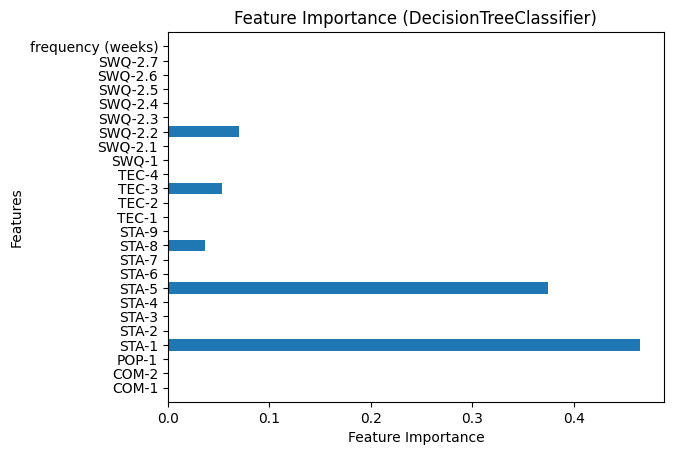

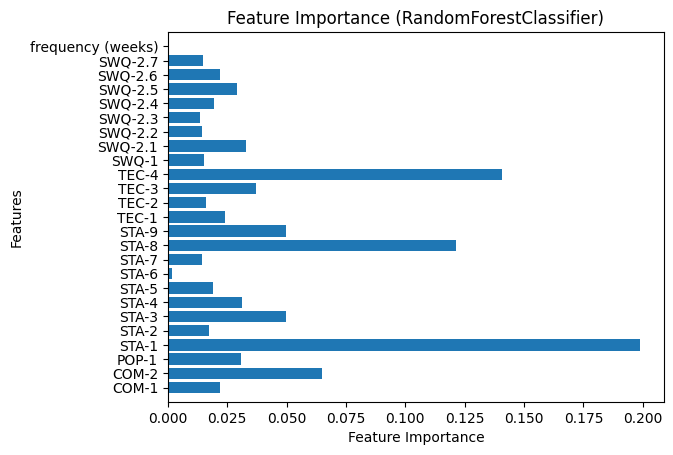

SVC does not have feature importances.


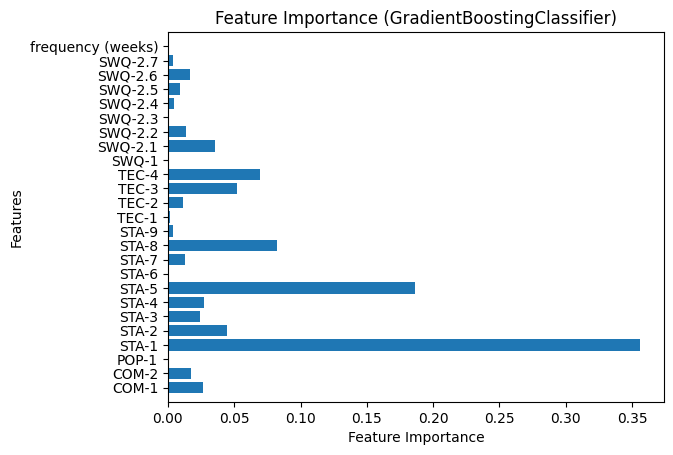

In [37]:
def plot_feature_importances(model, feature_names):
    if hasattr(model, 'feature_importances_'):
        # For models that have feature_importances_
        n_features = len(feature_names)
        plt.barh(np.arange(n_features), model.feature_importances_, align='center')
        plt.yticks(np.arange(n_features), feature_names)
        plt.xlabel("Feature Importance")
        plt.ylabel("Features")
        plt.ylim(-1, n_features)
        plt.title(f"Feature Importance ({model.__class__.__name__})")
        plt.show()
    else:
        print(f"{model.__class__.__name__} does not have feature importances.")

for name, model in best_models.items():
    plot_feature_importances(model, X.columns.tolist())


## SHAP - SHapley Additive exPlanations
SHAP is a way of getting a consistent and objective explanation of how each feature impacts the model's prediction. This way, we can confirm whether a high value for a specific feature will count more towards 'Sustainable' or 'Unsustainable'

For tree-based models (Decision Tree, Random Forest, Gradient Boosting), we use shap.TreeExplainer to compute SHAP values and then generate a summary plot

For models like Naive Bayes, Logistic Regression, and Support Vector Machine, we use shap.KernelExplainer. A smaller background sample is chosen to speed up computation, and we compute SHAP values on a subset of the test set.

In [1]:
#SHAP for tree-based models
tree_based_models = ['Decision Tree','Random Forest','Gradient Boosting']

for name in tree_based_models:
    print(best_models[name])
    model = best_models[name]
    explainer = shap.TreeExplainer(model)
    print(X_test.shape)
    shap_values = explainer.shap_values(X_test)
    print(shap_values.shape)
    print(f"\nSHAP Summary Plot for {name}")
    print(model.classes_)
    if shap_values.ndim == 3:
        shap.summary_plot(shap_values[:,:,1], X_test, rng=np.random.default_rng(42))
    else:
        shap.summary_plot(shap_values, X_test, rng=np.random.default_rng(42))
    


NameError: name 'best_models' is not defined

In [ ]:
#SHAP for non-tree-based models
background = X_train.sample(100, random_state=random_seed) #Subset of training data as background for KernelExplainer

non_tree_models = ['Naive Bayes', 'Logistic Regression','Support Vector Machine']

for name in non_tree_models:
    model = best_models[name]
    
    if hasattr(model, "predict_proba"):
         func = lambda L: np.asarray(
            model.predict_proba(pd.DataFrame(L, columns=X_train.columns)),
            dtype=float
        ) 
    else:
        func = lambda L: np.asarray(
            model.predict(pd.DataFrame(L, columns=X_train.columns)),
            dtype=float
        )
        
    explainer = shap.KernelExplainer(func, background)
    X_test_subset = X_test.iloc[:100] #Create subset for faster processing (not incl. the background)
    shap_values = explainer.shap_values(X_test_subset)
    
    print(f"\nSHAP Summary Plot for {name}")
    print("Classes:",model.classes_)
    shap.summary_plot(shap_values[:,:,1], X_test_subset, rng=np.random.default_rng(42))